<a href="https://colab.research.google.com/github/DAG00DAG33/ML-Languages/blob/master/Pytorch/Pytorch_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch #
import torch.nn as nn #
import torch.optim as optim #
import torch.nn.functional as F

import numpy as np

from PIL import Image #
import matplotlib.pyplot as plt #

import torchvision.transforms as transforms #
import torchvision


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import data

In [0]:
import pickle
import h5py

DATA_PATH = '/content/drive/My Drive/ML/Lenguajes/datasets/'
with open(DATA_PATH + "Names.txt", "rb") as fp:   # Unpickling
  Names = pickle.load(fp)
  
  
dataset = h5py.File(DATA_PATH + "facesDatabase.h5", "r")
X_orig = np.array(dataset["X"][:]) 
X = X_orig/255.
X = np.moveaxis(X, 3, 1)

In [0]:
BATCH_SIZE = 100

In [0]:
transform = transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor()])
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)


tensor_x = torch.stack([torch.Tensor(X[i]) for i in range(X.shape[0])])

my_dataset = torch.utils.data.TensorDataset(tensor_x) # create your datset
trainloader = torch.utils.data.DataLoader(my_dataset, batch_size=BATCH_SIZE, shuffle=True) # create your dataloader

In [0]:
dataiter = iter(trainloader)
images = dataiter.next()[0]

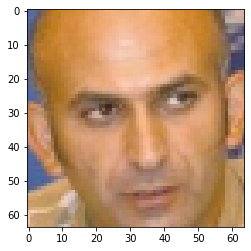

In [54]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    plt.figure()
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    if len(image.shape) == 4:
      image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)



imshow(images[0])

#Model

In [0]:
IN_SHAPE = (3,64,64)

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [57]:
class Encoder(nn.Module):
    def __init__(self, input_shape, num_classes, dropout_prob=0.3):
        super(Encoder, self).__init__()
        self.pipe = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=120,
                      kernel_size=8, stride=1, padding=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=120, out_channels=160,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=160, out_channels=200,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=200, out_channels=240,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=240, out_channels=240,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            Flatten(),
            nn.BatchNorm1d(3840),
            nn.Linear(3840, 300),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.pipe(x)


encoder = Encoder(IN_SHAPE, 6).to(device)
encoder(images.to(device))

tensor([[0.0065, 0.0022, 0.0015,  ..., 0.0037, 0.0036, 0.0027],
        [0.0020, 0.0038, 0.0021,  ..., 0.0026, 0.0032, 0.0023],
        [0.0061, 0.0016, 0.0030,  ..., 0.0029, 0.0009, 0.0024],
        ...,
        [0.0021, 0.0043, 0.0025,  ..., 0.0008, 0.0025, 0.0024],
        [0.0020, 0.0045, 0.0068,  ..., 0.0024, 0.0029, 0.0047],
        [0.0027, 0.0036, 0.0035,  ..., 0.0024, 0.0034, 0.0032]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [58]:
from torchsummary  import summary
summary(encoder, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 64, 64]               6
            Conv2d-2          [-1, 120, 65, 65]          23,160
              ReLU-3          [-1, 120, 65, 65]               0
         MaxPool2d-4          [-1, 120, 32, 32]               0
            Conv2d-5          [-1, 160, 32, 32]         172,960
              ReLU-6          [-1, 160, 32, 32]               0
         MaxPool2d-7          [-1, 160, 16, 16]               0
            Conv2d-8          [-1, 200, 16, 16]         288,200
              ReLU-9          [-1, 200, 16, 16]               0
        MaxPool2d-10            [-1, 200, 8, 8]               0
           Conv2d-11            [-1, 240, 8, 8]         432,240
             ReLU-12            [-1, 240, 8, 8]               0
        MaxPool2d-13            [-1, 240, 4, 4]               0
           Conv2d-14            [-1, 24

In [0]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


In [60]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.pipe = nn.Sequential(
            nn.Linear(300, 3840),
            Reshape(-1,240,4,4),
            nn.Conv2d(in_channels=240, out_channels=240,
                      kernel_size=9, stride=1, padding=4),
            nn.BatchNorm2d(240),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=240, out_channels=240,
                      kernel_size=15, stride=1, padding=7),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=240, out_channels=200,
                      kernel_size=15, stride=1, padding=7),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=200, out_channels=160,
                      kernel_size=15, stride=1, padding=7),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=160, out_channels=120,
                      kernel_size=15, stride=1, padding=7),
            nn.ReLU(),
            nn.BatchNorm2d(120),
            nn.Conv2d(in_channels=120, out_channels=3,
                      kernel_size=9, stride=1, padding=4),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.pipe(x)


decoder = Decoder().to(device)
pre = decoder(encoder(images.to(device)))
pre.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([100, 3, 64, 64])

In [61]:
from torchsummary  import summary
summary(decoder, (300,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3840]       1,155,840
           Reshape-2            [-1, 240, 4, 4]               0
            Conv2d-3            [-1, 240, 4, 4]       4,665,840
       BatchNorm2d-4            [-1, 240, 4, 4]             480
              ReLU-5            [-1, 240, 4, 4]               0
          Upsample-6            [-1, 240, 8, 8]               0
            Conv2d-7            [-1, 240, 8, 8]      12,960,240
              ReLU-8            [-1, 240, 8, 8]               0
          Upsample-9          [-1, 240, 16, 16]               0
           Conv2d-10          [-1, 200, 16, 16]      10,800,200
             ReLU-11          [-1, 200, 16, 16]               0
         Upsample-12          [-1, 200, 32, 32]               0
           Conv2d-13          [-1, 160, 32, 32]       7,200,160
             ReLU-14          [-1, 160,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


#Load model

In [70]:
CHK_PATH = '/content/drive/My Drive/ML/Lenguajes/Pytorch/checkpoints/'
cuda = torch.cuda.is_available()
if cuda:
    checkpoint = torch.load(CHK_PATH + 'FacesCheckpoint.pth.tar')
else:
    # Load GPU model on CPU
    checkpoint = torch.load(resume_weights,
                            map_location=lambda storage,
                            loc: storage)
start_epoch = checkpoint['epoch']
best_epochLoss = checkpoint['best_epochLoss']
encoder.load_state_dict(checkpoint['encoder_dict'])
decoder.load_state_dict(checkpoint['decoder_dict'])
losses = checkpoint['losses']
print("=> loaded checkpoint '{}' (trained for {} epochs)".format("a", checkpoint['epoch']))

FileNotFoundError: ignored

#Train

In [0]:

def save_checkpoint(state, is_best, filename=CHK_PATH + 'FacesCheckpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Loss did not improve")

In [72]:
lossFunc = nn.MSELoss()
#lossFunc = nn.BCELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)


def train(encoder, decoder, enc_optimizer, dec_optimazer, trainloader, epochs, device, losses=[], start_epoch=0, best_epochLoss=99999):
    #model.train()
    n=4
    running_loss = 0.0
    for epoch in range(start_epoch, epochs + start_epoch):
      epochLoss = 0
      for i, data in enumerate(trainloader, 0):
          # get the inputs
          images = data[0].to(device) 
          #labels = labels.to(device=device, dtype=torch.int64)
          enc_optimizer.zero_grad()
          dec_optimizer.zero_grad()

          enc = encoder(images)
          pre = decoder(enc)

          loss = lossFunc(images, pre)

          loss.backward()

          enc_optimizer.step()
          dec_optimizer.step()

          running_loss += loss.item()
          if i % n == n-1: 
              print('[%d, %5d] loss: %.7f' %
                    (epoch + 1, (i + 1)*BATCH_SIZE, running_loss / (BATCH_SIZE*n)))
              losses.append(running_loss / (BATCH_SIZE*n))
              epochLoss+=running_loss
              running_loss = 0.0

      if epoch==0 : best_epochLoss = epochLoss 
      is_best = bool(epochLoss < best_epochLoss)
      # best_epochLoss = torch.FloatTensor(max(epochLoss.numpy(), best_epochLoss.numpy()))
      if epochLoss < best_epochLoss: best_epochLoss=epochLoss
      save_checkpoint({
          'epoch': start_epoch + epoch + 1,
          'encoder_dict': encoder.state_dict(),
          'decoder_dict': decoder.state_dict(),
          'best_epochLoss': best_epochLoss,
          'losses': losses
      }, is_best)
      print("[" + str(epochLoss) + "," + str(best_epochLoss) + "]")

    return epochs + start_epoch, best_epochLoss, losses


start_epoch, best_epochLoss, losses = train(encoder, decoder, enc_optimizer, dec_optimizer, trainloader, 2, 
               device,losses=losses, start_epoch=start_epoch, best_epochLoss=best_epochLoss)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[288,   400] loss: 0.0000622
[288,   800] loss: 0.0000619
[288,  1200] loss: 0.0000606
[288,  1600] loss: 0.0000570
[288,  2000] loss: 0.0000570
[288,  2400] loss: 0.0000584
[288,  2800] loss: 0.0000591
[288,  3200] loss: 0.0000603
[288,  3600] loss: 0.0000598
[288,  4000] loss: 0.0000578
[288,  4400] loss: 0.0000577
[288,  4800] loss: 0.0000584
[288,  5200] loss: 0.0000583
[288,  5600] loss: 0.0000595
=> Saving a new best
[0.3312883717007935,0.3312883717007935]
[289,   400] loss: 0.0000747
[289,   800] loss: 0.0000565
[289,  1200] loss: 0.0000606
[289,  1600] loss: 0.0000554
[289,  2000] loss: 0.0000565
[289,  2400] loss: 0.0000580
[289,  2800] loss: 0.0000571
[289,  3200] loss: 0.0000584
[289,  3600] loss: 0.0000589
[289,  4000] loss: 0.0000580
[289,  4400] loss: 0.0000574
[289,  4800] loss: 0.0000585
[289,  5200] loss: 0.0000609
[289,  5600] loss: 0.0000580
=> Loss did not improve
[0.3315690611489117,0.3312883717007935]


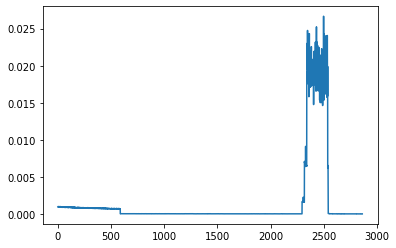

In [65]:
plt.plot(losses[80:])

In [0]:
l=[]
for i in range(34):
  l.append(sum(losses[i*19:i*19+19])/19)

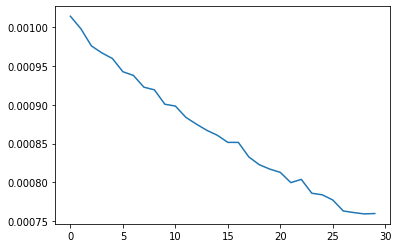

In [67]:
plt.plot(l[4:])

In [68]:
pre = decoder(encoder(images.to(device)))
pre.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([100, 3, 64, 64])

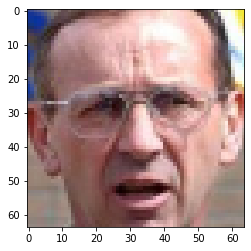

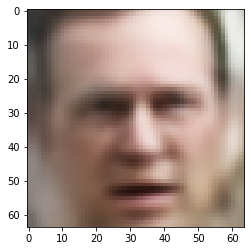

In [69]:
imshow(images[1])
imshow(pre[1])